<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/symplectic_Euler_energy_preserved_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
#simplektik euler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

#np.random.seed(1)
#tf.random.set_seed(1)

In [87]:
def grand_truth_plot(h = 0.3):
  t = np.arange(0,2*np.pi,h)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.ylabel('p', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.title("Phase Diagram", fontsize=17,fontweight="bold",fontname="Times New Roman")

In [88]:
# Hamiltonian Equation

def T(p):
  return (p**2)/2

def V(q):
  return (q**2)/2

def H(q,p):
  return T(p) + V(q)

In [89]:
def dV(q_0=tf.constant(1.0)):
  q_0 = tf.constant(q_0)
  with tf.GradientTape() as g:
    g.watch(q_0)
    y = V(q_0)
  return g.gradient(y, q_0)

def dT(p_0=tf.constant(1.0)):
  p_0 = tf.constant(p_0)
  with tf.GradientTape() as g:
    g.watch(p_0)
    y = T(p_0)
  return g.gradient(y, p_0)

In [90]:
def symplectic_euler(dT=dT, dV=dV ,h=0.5, initial_point= [0., 1.]):

  t = np.arange(0, 2*np.pi, h)

  q = np.zeros(t.shape[0])
  p = np.zeros(t.shape[0])

  q[0] = initial_point[0]
  p[0] = initial_point[1]
  
  for i in range(0, t.shape[0]-1):

    q[i + 1] = q[i] + h * dT(p[i])
    p[i + 1] = p[i] - h * dV(q[i+1])
  
  z = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)
  return z, t

In [91]:
z, t = symplectic_euler()
print("shape of q :", z[:,0].shape ,"\nshape of p:", z[:,1].shape, "\nsize of t:", len(t))

shape of q : (13,) 
shape of p: (13,) 
size of t: 13


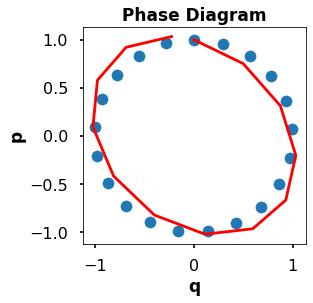

In [92]:
plt.figure(figsize = (4, 4))

# Simplectic solution plot
pred_plot(q=z[:,0], p=z[:,1])

# Grand truth solution plot
grand_truth_plot()
plt.show()

In [93]:
def NN(input =1, output=2, hidden_layer=2, neuron=32, activation="relu", energy_loss=None):
  # Neural network with MSE loss
  np.random.seed(1)
  tf.random.set_seed(1)

  inp = Input(shape=(input,), name= "Input_Layer")
  for i in range(0,hidden_layer):
    if i == 0:
      x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(inp)
    else:
      x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(x)
  x = Dense(output, name="Ourput_Layer")(x)
  

  out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x

  return Model(inputs=inp, outputs=out)

In [94]:
def train(model,input, target, learning_rate=0.0003, loss="mse", batch_size=10000, epochs=2000):
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss=loss)
  model.fit(x=input, y=target, epochs=epochs, batch_size=batch_size)
  return model

In [95]:
model = NN(input= 1,output=2, hidden_layer=20, neuron=32, activation=tf.math.sin)
model_train = train(model=model, input=t, target=z, learning_rate=0.0003, loss="mse", batch_size=10000, epochs=10000)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 19ms/step - loss: 7.9848e-07
Epoch 7502/10000
1/1 [==============================] - 0s 15ms/step - loss: 1.0070e-06
Epoch 7503/10000
1/1 [==============================] - 0s 18ms/step - loss: 1.2298e-06
Epoch 7504/10000
1/1 [==============================] - 0s 16ms/step - loss: 1.3650e-06
Epoch 7505/10000
1/1 [==============================] - 0s 15ms/step - loss: 1.3671e-06
Epoch 7506/10000
1/1 [==============================] - 0s 15ms/step - loss: 1.2480e-06
Epoch 7507/10000
1/1 [==============================] - 0s 9ms/step - loss: 1.0626e-06
Epoch 7508/10000
1/1 [==============================] - 0s 8ms/step - loss: 8.7805e-07
Epoch 7509/10000
1/1 [==============================] - 0s 8ms/step - loss: 7.4812e-07
Epoch 7510/10000
1/1 [==============================] - 0s 16ms/step - loss: 6.9720e-07
Epoch 7511/10000
1/1 [==============================] - 0s 18ms/step - loss: 7.1897e-07
Epoch

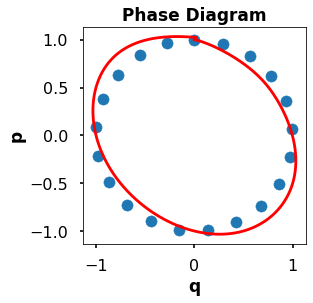

In [96]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction = model_train(test_t)

q = prediction[:,0]
p = prediction[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q, p )

# Grand truth solution plot
grand_truth_plot()

plt.show()

In [97]:
# Energy loss function
def custom_loss(y_true, y_pred):
  return tf.keras.losses.MSE(0.5, H(y_pred[None,:,0], y_pred[None, :,1])) +  0.01 * tf.keras.losses.MSE(y_true,y_pred)

In [98]:
energy_model = NN(input= 1,output=2, hidden_layer=20, neuron=32, activation=tf.math.sin, energy_loss=custom_loss)

In [99]:
# Parametreleri atama ve veri arttırma
energy_model.set_weights(model_train.get_weights())

t_created = np.arange(0, 2*np.pi, 0.0003)
target_created = model_train(t_created)

In [100]:
t_created.shape

(20944,)

In [101]:
energy_model_train = train(model=energy_model, input=t_created, target=target_created, learning_rate=0.0003, loss=custom_loss, batch_size=10000, epochs=10000)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
3/3 [==============================] - 0s 58ms/step - loss: 4.5221e-05
Epoch 7502/10000
3/3 [==============================] - 0s 69ms/step - loss: 4.5252e-05
Epoch 7503/10000
3/3 [==============================] - 0s 55ms/step - loss: 4.5245e-05
Epoch 7504/10000
3/3 [==============================] - 0s 55ms/step - loss: 4.5253e-05
Epoch 7505/10000
3/3 [==============================] - 0s 57ms/step - loss: 4.5233e-05
Epoch 7506/10000
3/3 [==============================] - 0s 51ms/step - loss: 4.5270e-05
Epoch 7507/10000
3/3 [==============================] - 0s 56ms/step - loss: 4.5232e-05
Epoch 7508/10000
3/3 [==============================] - 0s 54ms/step - loss: 4.5291e-05
Epoch 7509/10000
3/3 [==============================] - 0s 55ms/step - loss: 4.5374e-05
Epoch 7510/10000
3/3 [==============================] - 0s 57ms/step - loss: 4.5238e-05
Epoch 7511/10000
3/3 [==============================] - 0s 56ms/step - loss: 4.5218e-05
Ep

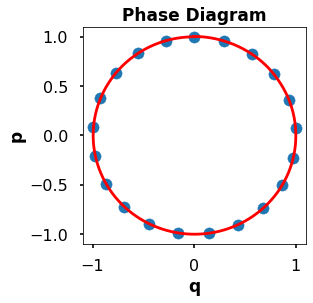

In [102]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction_energy = energy_model_train(test_t)

q_energy = prediction_energy[:,0]
p_energy = prediction_energy[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q_energy, p_energy )

# Grand truth solution plot
grand_truth_plot()

plt.show()

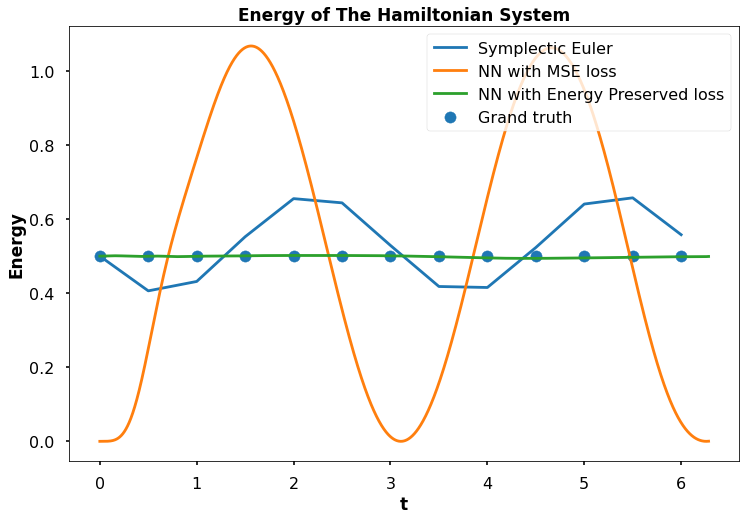

In [103]:
plt.figure(figsize=(12,8))

plt.scatter(t, [0.5 for i in range(t.shape[0])], label="Grand truth")
plt.plot(t , H(z[:,0], z[:,1]), label="Symplectic Euler")
plt.plot(test_t, H(model_train(test_t)[:,0], model_train(test_t)[:,0]), label="NN with MSE loss")
plt.plot(test_t, H(energy_model_train(test_t)[:,0], energy_model_train(test_t)[:,1]), label="NN with Energy Preserved loss")

plt.title("Energy of The Hamiltonian System", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.xlabel("t", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.ylabel("Energy", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.legend(loc="upper right")
plt.show()

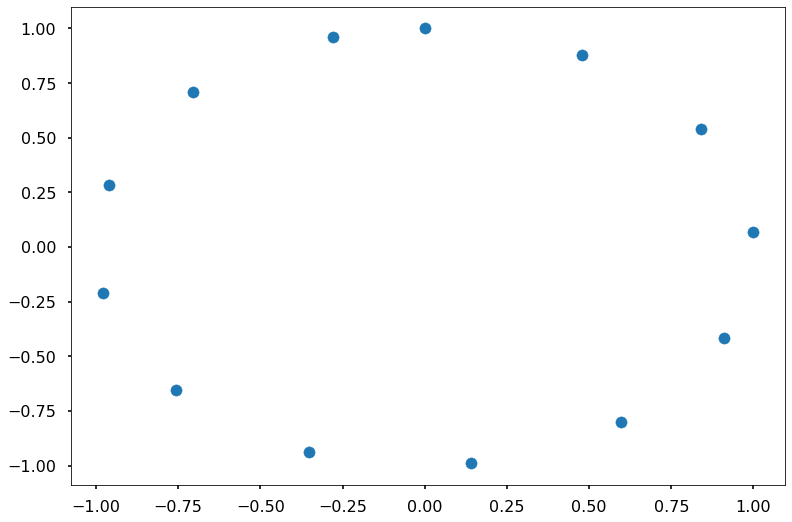

In [104]:
grand_truth = np.concatenate((np.sin(t).reshape(-1,1), (np.cos(t).reshape(-1,1))), axis=1)
grand_truth_1 = np.concatenate((np.sin(test_t).reshape(-1,1), (np.cos(test_t).reshape(-1,1))), axis=1)
plt.scatter(grand_truth[:,0], grand_truth[:,1])

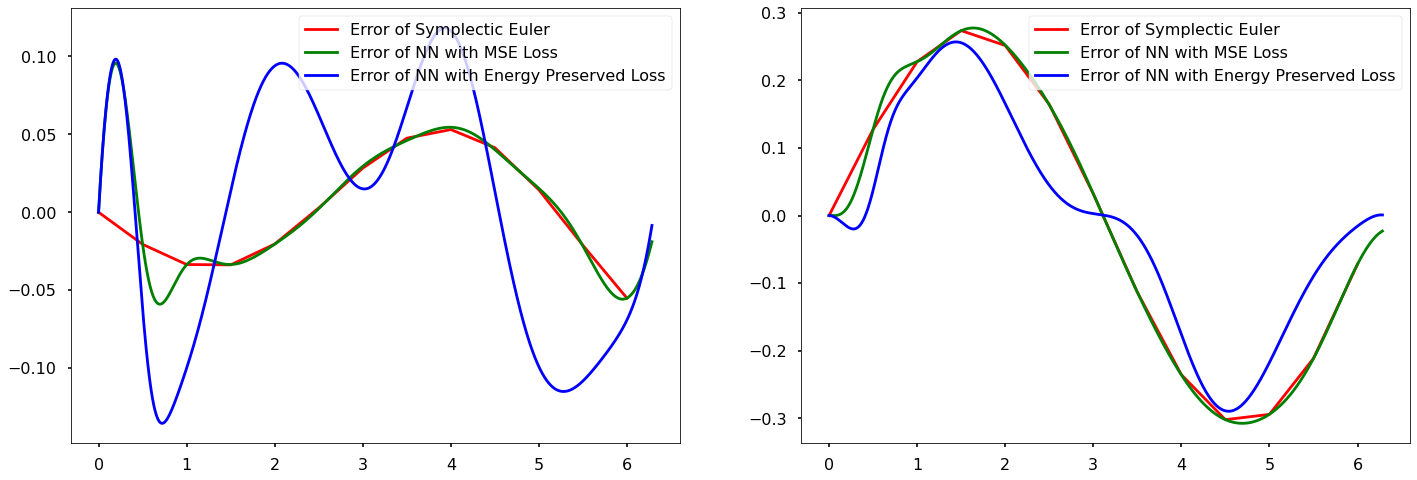

In [105]:
# Symplectic
plt.figure(figsize=(24,8))

plt.subplot(121)
plt.plot(t, grand_truth[:,0] - z[:,0], c = 'r', label="Error of Symplectic Euler")
plt.plot(test_t, grand_truth_1[:,0] - model_train(test_t)[:,0], c= 'g', label="Error of NN with MSE Loss")
plt.plot(test_t, grand_truth_1[:,0] - energy_model_train(test_t)[:,0] , c='b', label="Error of NN with Energy Preserved Loss")
plt.legend(loc="upper right")

plt.subplot(122)
plt.plot(t, grand_truth[:,1] - z[:,1], c = 'r', label="Error of Symplectic Euler")
plt.plot(test_t, grand_truth_1[:,1] - model_train(test_t)[:,1], c= 'g', label="Error of NN with MSE Loss")
plt.plot(test_t, grand_truth_1[:,1] - energy_model_train(test_t)[:,1] , c='b', label="Error of NN with Energy Preserved Loss")
plt.legend(loc="upper right")

In [106]:
model_train(np.array([0.]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>